## Apply PCA to gene dependencies

Principal component analysis (PCA) is a commonly-used dimensionality reduction method that finds components that explain orthogonal variation in the data in a descending fashion.

We apply it to GeneEffect scores here and save latent representations (PCA components) for downstream comparative analyses (to compare with BetaVAE).

In [1]:
import sys
import pathlib
import pandas as pd
import plotnine as gg
from sklearn.decomposition import PCA

sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_train_test_data

In [2]:
data_directory = pathlib.Path("../0.data-download/data")
dependency_file = pathlib.Path(f"{data_directory}/CRISPRGeneEffect.parquet")
gene_dict_file = pathlib.Path(f"{data_directory}/CRISPR_gene_dictionary.tsv")

output_dir = pathlib.Path("results")
pca_output_file = pathlib.Path(f"{output_dir}/pca_latent.parquet.gz")
output_pca_weights_file = pathlib.Path(f"{output_dir}/PCA_weight_matrix_gsea.parquet")

In [3]:
pca_components = 50

In [4]:
# Load gene dependency data
dependency_df = pd.read_parquet(dependency_file)

print(dependency_df.shape)
dependency_df.head(3)

(1095, 17932)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,-0.102725,0.058595,0.058246,-0.041881,-0.088661,0.170335,-0.015254,-0.223691,0.218612,...,-0.084055,-0.084184,0.131495,0.238702,0.201712,-0.250381,0.045612,0.044154,0.146801,-0.473583
1,ACH-000004,0.008878,-0.077633,-0.099297,0.030120,-0.080334,-0.112404,0.298774,-0.125139,0.218675,...,-0.066673,-0.443145,0.183618,0.058936,0.108711,0.056322,-0.355712,0.135310,0.200408,-0.076150
2,ACH-000005,-0.117950,0.013989,0.164099,0.184570,-0.201766,-0.202198,0.207814,-0.089192,-0.082624,...,-0.151588,-0.402572,-0.073320,-0.114402,-0.009449,-0.198378,-0.135007,0.014708,-0.065341,-0.196296


In [5]:
# Load gene dictionary (with QC columns)
gene_dict_df = (
    pd.read_parquet(gene_dict_file, sep="\t")
    .query("qc_pass")
    .reset_index(drop=True)
)
gene_dict_df.entrez_id = gene_dict_df.entrez_id.astype(str)

print(gene_dict_df.shape)
gene_dict_df.head(3)

(2768, 6)


,entrez_id,symbol_id,dependency_column,qc_pass_pan,qc_pass_other,qc_pass
0,8086,AAAS,AAAS (8086),True,True,True
1,14,AAMP,AAMP (14),True,True,True
2,16,AARS1,AARS1 (16),True,True,True


## Subset input data to common gene sets

In [6]:
# Recode column names to entrez ids
entrez_genes = [x[1].strip(")").strip() for x in dependency_df.iloc[:, 1:].columns.str.split("(")]

entrez_intersection = list(
    set(gene_dict_df.entrez_id).intersection(set(entrez_genes))
)

print(len(entrez_intersection))

gene_dict_df = gene_dict_df.set_index("entrez_id").reindex(entrez_intersection)
gene_dict_df.head(3)

2768


,symbol_id,dependency_column,qc_pass_pan,qc_pass_other,qc_pass
entrez_id,,,,,
220359,TIGD3,TIGD3 (220359),True,True,True
56915,EXOSC5,EXOSC5 (56915),True,True,True
11260,XPOT,XPOT (11260),True,True,True


In [7]:
# Subset dependencies to the genes that passed qc
dependency_df.columns = ["ModelID"] + entrez_genes

dependency_df = dependency_df.loc[:, ["ModelID"] + gene_dict_df.index.tolist()]
dependency_df.columns = ["ModelID"] + gene_dict_df.symbol_id.tolist()

dependency_df = dependency_df.dropna(axis="columns")

print(dependency_df.shape)
dependency_df.head()

(1095, 2733)


,ModelID,TIGD3,EXOSC5,XPOT,SF3B4,CCT4,KARS1,BUD23,RBM18,GALE,...,MARS2,MIS18A,TMEM199,CAB39,FAM32A,UBE2D3,EIF3F,SREBF2,BIRC6,CHAMP1
0,ACH-000001,-0.532566,-1.119344,-0.423292,-2.618597,-2.769668,-2.098455,-1.719612,-0.517277,-0.367546,...,-0.793026,-0.725349,-0.546638,-0.323173,-1.236042,-0.684816,-1.661823,-0.071150,-1.127613,0.014170
1,ACH-000004,-0.041110,-0.682417,-0.622683,-2.281493,-2.402168,-1.841728,-1.505402,-0.027155,-0.439104,...,-0.815042,-0.870954,-0.696801,-0.064219,-0.434327,-1.010587,-1.676536,0.021463,-0.722786,-0.246531
2,ACH-000005,0.204401,-0.916891,-0.544614,-2.054137,-2.198328,-1.112096,-1.377928,0.085519,-0.228975,...,-0.697991,-0.791296,-0.578638,-0.574034,-0.275383,-0.865434,-2.053222,-0.015941,-0.540276,-0.110517
3,ACH-000007,-0.073186,-0.985003,-0.535991,-1.322125,-1.297592,-0.922105,-1.426265,-0.064648,-0.331958,...,-0.866429,-0.741094,-1.067940,-0.007378,-0.784184,-1.020735,-1.896998,-0.077670,0.015155,-0.315176
4,ACH-000009,-0.107590,-0.950854,-0.878022,-2.523339,-2.102818,-1.695866,-1.122433,-0.242300,-0.075205,...,-0.458656,-1.141959,-0.600628,-0.051933,-0.752741,-0.572551,-1.882181,-0.132155,-0.309590,-0.053398


# Perform PCA

In [8]:
pca = PCA(n_components=pca_components)
pca.fit(dependency_df.drop(columns=["ModelID"]))

PCA(n_components=50)

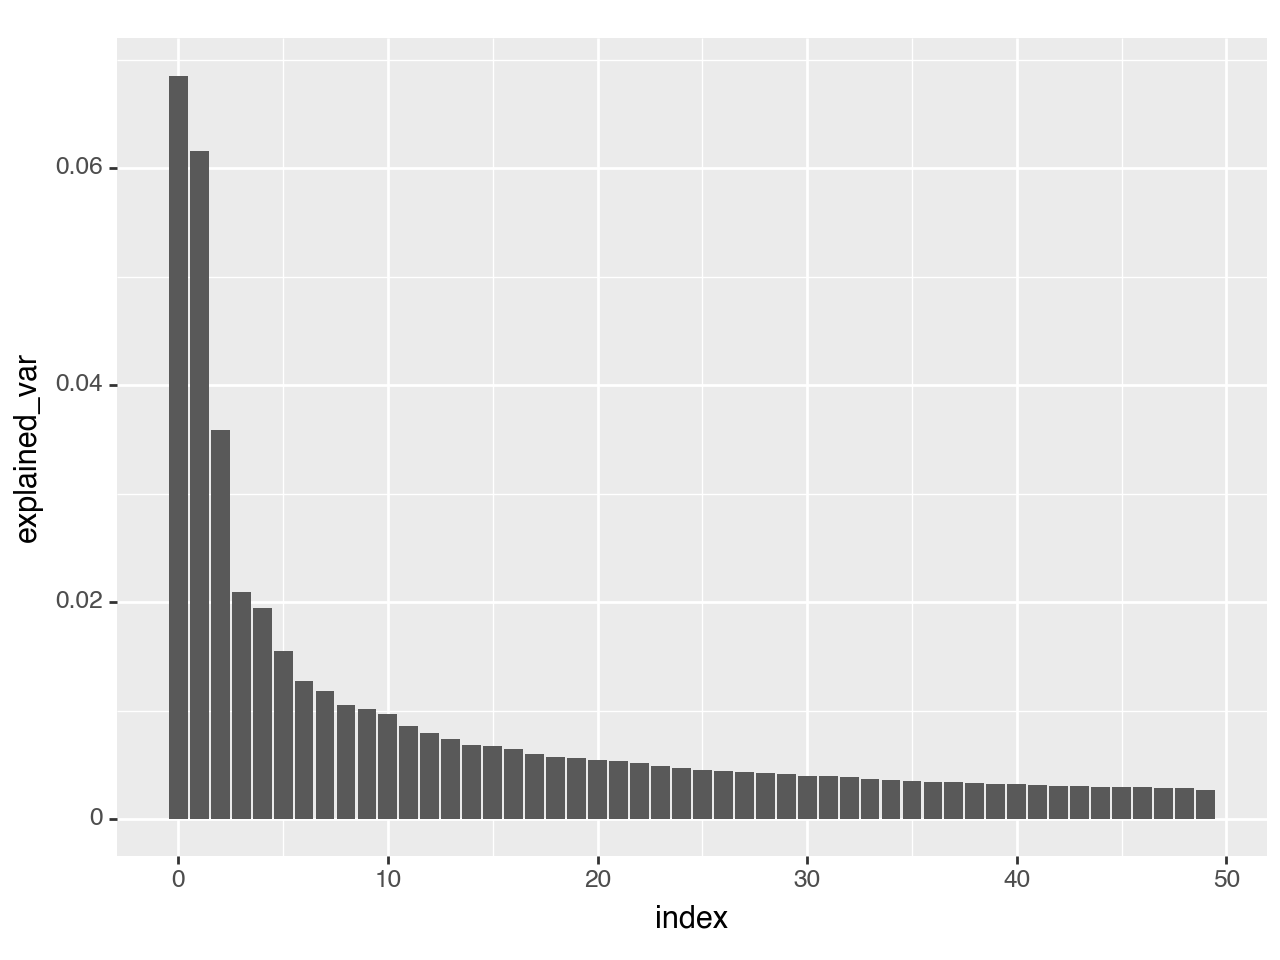

<Figure Size: (640 x 480)>

In [9]:
# Output explained variance and quickly visualize
explained_var = pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_var"]).reset_index()

(
    gg.ggplot(explained_var, gg.aes(x="index", y="explained_var"))
    + gg.geom_bar(stat="identity")
)

In [10]:
# Transform models into pca space
dependency_df_transformed = pd.DataFrame(
    pca.transform(dependency_df.drop(columns=["ModelID"]))
)

# Recode column space and add back model IDs
dependency_df_transformed.columns = [f"PCA_{x}" for x in range(0, dependency_df_transformed.shape[1])]
dependency_df_transformed = pd.concat([dependency_df.loc[:, "ModelID"], dependency_df_transformed], axis="columns")

dependency_df_transformed.to_parquet(pca_output_file, sep=",", index=False)

print(dependency_df_transformed.shape)
dependency_df_transformed.head(3)

(1095, 51)


,ModelID,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,ACH-000001,-1.165179,3.085481,2.953869,4.612329,-1.540851,-1.627143,-1.246527,-0.514232,1.920746,...,0.982560,0.180836,1.461337,0.099997,-0.800802,-1.612915,-0.168786,-1.462745,-0.276488,0.475357
1,ACH-000004,5.357760,1.083694,2.054472,-3.361544,0.905552,-2.288749,-1.482409,-1.229408,1.061975,...,0.409203,-0.907242,0.495173,0.152615,0.851586,0.735178,-1.434756,-0.365414,-0.922596,0.148843
2,ACH-000005,7.283533,4.596063,1.446880,-2.944721,1.755861,-4.092541,-1.750577,1.534044,0.170318,...,0.522839,-0.012296,0.759785,0.485698,0.746930,0.357170,-0.717016,-0.264409,0.169518,0.073974


In [11]:
# Obtain weights, which can be used in GSEA
pca_weights = pd.DataFrame(pca.components_, columns=dependency_df.drop(columns=["ModelID"]).columns.tolist()).transpose()
pca_weights.columns = [f"PCA_{x}" for x in range(0, pca_weights.shape[1])]

pca_weights = pca_weights.reset_index().rename(columns={"index": "genes"})

pca_weights.to_parquet(output_pca_weights_file, index=False)

print(pca_weights.shape)
pca_weights.head(3)

(2732, 51)


,genes,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,TIGD3,0.010714,0.001402,0.002633,-0.004015,0.009681,-0.003124,-0.001792,0.008347,-0.009286,...,-0.004950,0.006507,-0.007249,0.002603,0.000796,0.002430,-0.009665,0.004099,0.008760,0.003690
1,EXOSC5,0.022203,0.026663,0.001951,-0.001086,-0.003433,0.021470,-0.013724,-0.010994,0.004329,...,0.000890,-0.000323,0.008395,0.004357,0.008282,-0.002010,0.005371,-0.002132,-0.000260,-0.021927
2,XPOT,-0.004562,0.000938,0.013140,0.000832,0.006934,-0.009125,-0.010528,-0.007316,0.004086,...,-0.013424,0.020678,-0.011322,-0.005141,0.003696,0.002042,0.019125,0.036072,0.017552,0.019537
